In [1]:
import torch
import torch.nn as nn
import utils
import numpy as np
import torchvision.transforms.functional as TF
from torchvision import transforms
import models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import math
from utils import to_pixel_samples
from utils import make_coord
import argparse
import random
model_spec = torch.load("save/ssrtr-lte_2024-05-27/epoch-last.pth")['model']
net = models.make(model_spec, load_sd=True).cuda()
print(net)
# utils.load_checkpoint(net,'checkpoints\Deraining\models\deraindrop-best-03-16-2346-it2\model_latest.pth')

c:\ProgramData\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NAFLTEOURS(
  (encoder): StereoIR(
    (conv_first): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (patch_embed): PatchEmbed(
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (patch_unembed): PatchUnEmbed()
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): RSTB(
        (residual_group): BasicLayer(
          dim=96, input_resolution=(24, 96), depth=6
          (blocks): ModuleList(
            (0): StereoTransformerBlock(
              dim=96, input_resolution=(24, 96), num_heads=6, window_size=8, shift_size=0, mlp_ratio=4.0
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                dim=96, window_size=(8, 8), num_heads=6
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
    

In [2]:
features_in_hook = []
features_out_hook = []

def hook(module, fea_in, fea_out):
    features_in_hook.append(fea_in)
    features_out_hook.append(fea_out)

# layer_name = 'encoder.layers.0.residual_group.cross_attn'
layer_name = 'encoder'
for (name, module) in net.named_modules():
    if name == layer_name:
        module.register_forward_hook(hook=hook)

print(features_in_hook) 
print(features_out_hook)

[]
[]


In [3]:
def resize_fn(img, size):
    ### normalize and resize
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)
    transformer = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return transformer(img)

In [4]:
# img_path_L = r"/media/yi/E/Research/Datasets/Flickr1024/Test/001_L.png"
# img_path_R = r"/media/yi/E/Research/Datasets/Flickr1024/Test/001_R.png"
img_path_L = r"E:\Research\Datasets\Flickr1024\Test\001_L.png"
img_path_R = r"E:\Research\Datasets\Flickr1024\Test\001_R.png"
# img_path = r"E:\Research\Datasets\Deraindrop\test\test_b\data\53_rain.jpg"
# img_path = r"E:\Research\Datasets\Deraindrop\test\test_a\data\11_rain.png"
input_L = TF.to_tensor(Image.open(img_path_L))
input_R = TF.to_tensor(Image.open(img_path_R))
s = 4
h_lr, w_lr = 24, 96
w_hr = round(w_lr * s)
h_hr = round(h_lr * s)
x0 = random.randint(0, input_L.shape[-2] - h_hr)
y0 = random.randint(0, input_L.shape[-1] - w_hr)
cropl_hr = input_L[:, x0: x0 + h_hr, y0: y0 + w_hr]
cropl_lr = resize_fn(cropl_hr, (h_lr, w_lr))
cropr_hr = input_R[:, x0: x0 + h_hr, y0: y0 + w_hr]
cropr_lr = resize_fn(cropr_hr, (h_lr, w_lr))

hr_coord, hrl_rgb = to_pixel_samples(cropl_hr.contiguous())
cell = torch.ones_like(hr_coord)
cell[:, 0] *= 2 / cropl_hr.shape[-2]
cell[:, 1] *= 2 / cropl_hr.shape[-1]
cropl_lr = cropl_lr.unsqueeze(0).cuda()
cropr_lr = cropr_lr.unsqueeze(0).cuda()
cell = cell.unsqueeze(0).cuda()
hr_coord = hr_coord.unsqueeze(0).cuda()
print(cropl_lr)

tensor([[[[-1.5185, -1.5185, -1.5357,  ..., -1.7069, -1.1760,  0.1768],
          [-1.5185, -1.5357, -1.5357,  ..., -1.5870, -1.0904,  0.1254],
          [-1.5185, -1.5357, -1.5357,  ..., -1.8097, -1.1075,  0.1597],
          ...,
          [-1.5014, -1.5185, -1.5014,  ..., -1.7925, -0.8507, -0.1657],
          [-1.5014, -1.5185, -1.5014,  ..., -1.6898, -0.0801, -0.2513],
          [-1.5014, -1.5185, -1.5185,  ..., -1.5357,  0.0569, -0.3198]],

         [[-0.6527, -0.6527, -0.6702,  ..., -1.7031, -1.2129,  0.1176],
          [-0.6527, -0.6527, -0.6527,  ..., -1.6331, -1.1253,  0.0476],
          [-0.6527, -0.6527, -0.6527,  ..., -1.8256, -1.1253,  0.0651],
          ...,
          [-0.6176, -0.6176, -0.6176,  ..., -1.7731, -1.0028, -0.7052],
          [-0.6176, -0.6176, -0.6176,  ..., -1.6856, -0.2675, -0.7577],
          [-0.6176, -0.6176, -0.6176,  ..., -1.5280, -0.1450, -0.8277]],

         [[ 0.7228,  0.7228,  0.7228,  ..., -1.4384, -1.0550, -0.1661],
          [ 0.7228,  0.7228,  

In [5]:
# input = torch.randn(16,3,224,224)
_,output,_ = net(cropl_lr, cropr_lr, hr_coord, cell, s)
print(features_out_hook[0])
out = features_out_hook[0]

(tensor([[[[ 9.3073e-01,  2.3655e-01,  6.0415e-02,  ..., -1.7724e-01,
            2.7356e-01,  1.4280e+00],
          [ 1.6801e+00,  4.6998e-01,  8.2424e-01,  ...,  1.2537e+00,
            7.2420e-01,  8.1721e-01],
          [ 1.6995e+00,  9.5859e-01,  1.2779e+00,  ...,  1.1121e+00,
            9.5782e-01,  1.0981e+00],
          ...,
          [ 1.9093e+00,  9.4223e-01,  1.2307e+00,  ...,  7.6757e-01,
            1.4969e+00,  2.4207e-01],
          [ 1.7036e+00,  1.0521e+00,  1.1721e+00,  ...,  4.6224e-01,
            1.3577e+00,  1.3795e-01],
          [ 1.6611e+00,  1.3052e+00,  1.3504e+00,  ...,  1.0379e+00,
            1.5185e+00,  2.7451e-01]],

         [[-1.2114e-02,  2.8696e-01,  4.4507e-01,  ...,  1.6531e-03,
           -1.1870e-01, -8.3632e-01],
          [ 1.4433e-01,  3.4344e-01,  3.7494e-01,  ...,  7.8412e-01,
            1.2232e+00, -5.0400e-01],
          [ 3.1415e-01,  5.9869e-01,  5.8112e-01,  ...,  6.2010e-02,
            6.4597e-01, -7.8942e-01],
          ...,
    

In [11]:
pred, pred_disp, mask = output
print(pred_disp)
img = pred_disp.view(4*24, 4*96, 1).detach().cpu().numpy()
img = (img*255).round().astype(np.uint8).squeeze(-1)
print(img)
img = Image.fromarray(img,mode='L')
img.save('vis/out_disp.jpg')

tensor([[[0.3102],
         [0.3099],
         [0.3093],
         ...,
         [0.2620],
         [0.2560],
         [0.2572]]], device='cuda:0', grad_fn=<AddBackward0>)
[[79 79 79 ... 67 66 66]
 [79 79 79 ... 67 66 65]
 [79 79 78 ... 66 66 65]
 ...
 [80 79 78 ... 66 65 65]
 [79 79 78 ... 67 66 66]
 [79 79 78 ... 67 65 66]]


In [7]:
img = out.view(w_hr, w_hr, 3).detach().cpu().numpy()
fig = plt.figure(1, figsize=(30, 50))
img_plot = plt.imshow(img)


AttributeError: 'tuple' object has no attribute 'view'

tensor([[[[-0.1489, -0.2363, -0.2107,  ..., -0.1990, -0.0530, -0.2815],
          [-0.0627, -0.0796,  0.0130,  ..., -0.0916,  0.0764,  0.0376],
          [-0.0709,  0.0218,  0.0127,  ..., -0.0326, -0.0242,  0.0150],
          ...,
          [ 0.2628,  0.2855,  0.2936,  ...,  0.2546,  0.0744,  0.2564],
          [ 0.0397,  0.0980,  0.0554,  ...,  0.0139, -0.0685, -0.0944],
          [-0.0581, -0.1051, -0.0522,  ..., -0.1960,  0.0130, -0.1076]],

         [[-0.0423,  0.0532, -0.0347,  ...,  0.0180,  0.0631, -0.0174],
          [ 0.0461,  0.0328,  0.0232,  ...,  0.0172, -0.0493, -0.1110],
          [ 0.0198,  0.0384,  0.0096,  ...,  0.0558,  0.0133, -0.0711],
          ...,
          [ 0.1777,  0.2103,  0.2019,  ...,  0.1254,  0.0708,  0.2680],
          [ 0.0910,  0.0972,  0.0404,  ...,  0.0204, -0.0236,  0.0081],
          [-0.0247, -0.0806, -0.1003,  ..., -0.0475,  0.0501, -0.1438]],

         [[-0.1044,  0.0577,  0.1032,  ..., -0.0269, -0.0448, -0.0659],
          [-0.0501,  0.0338,  

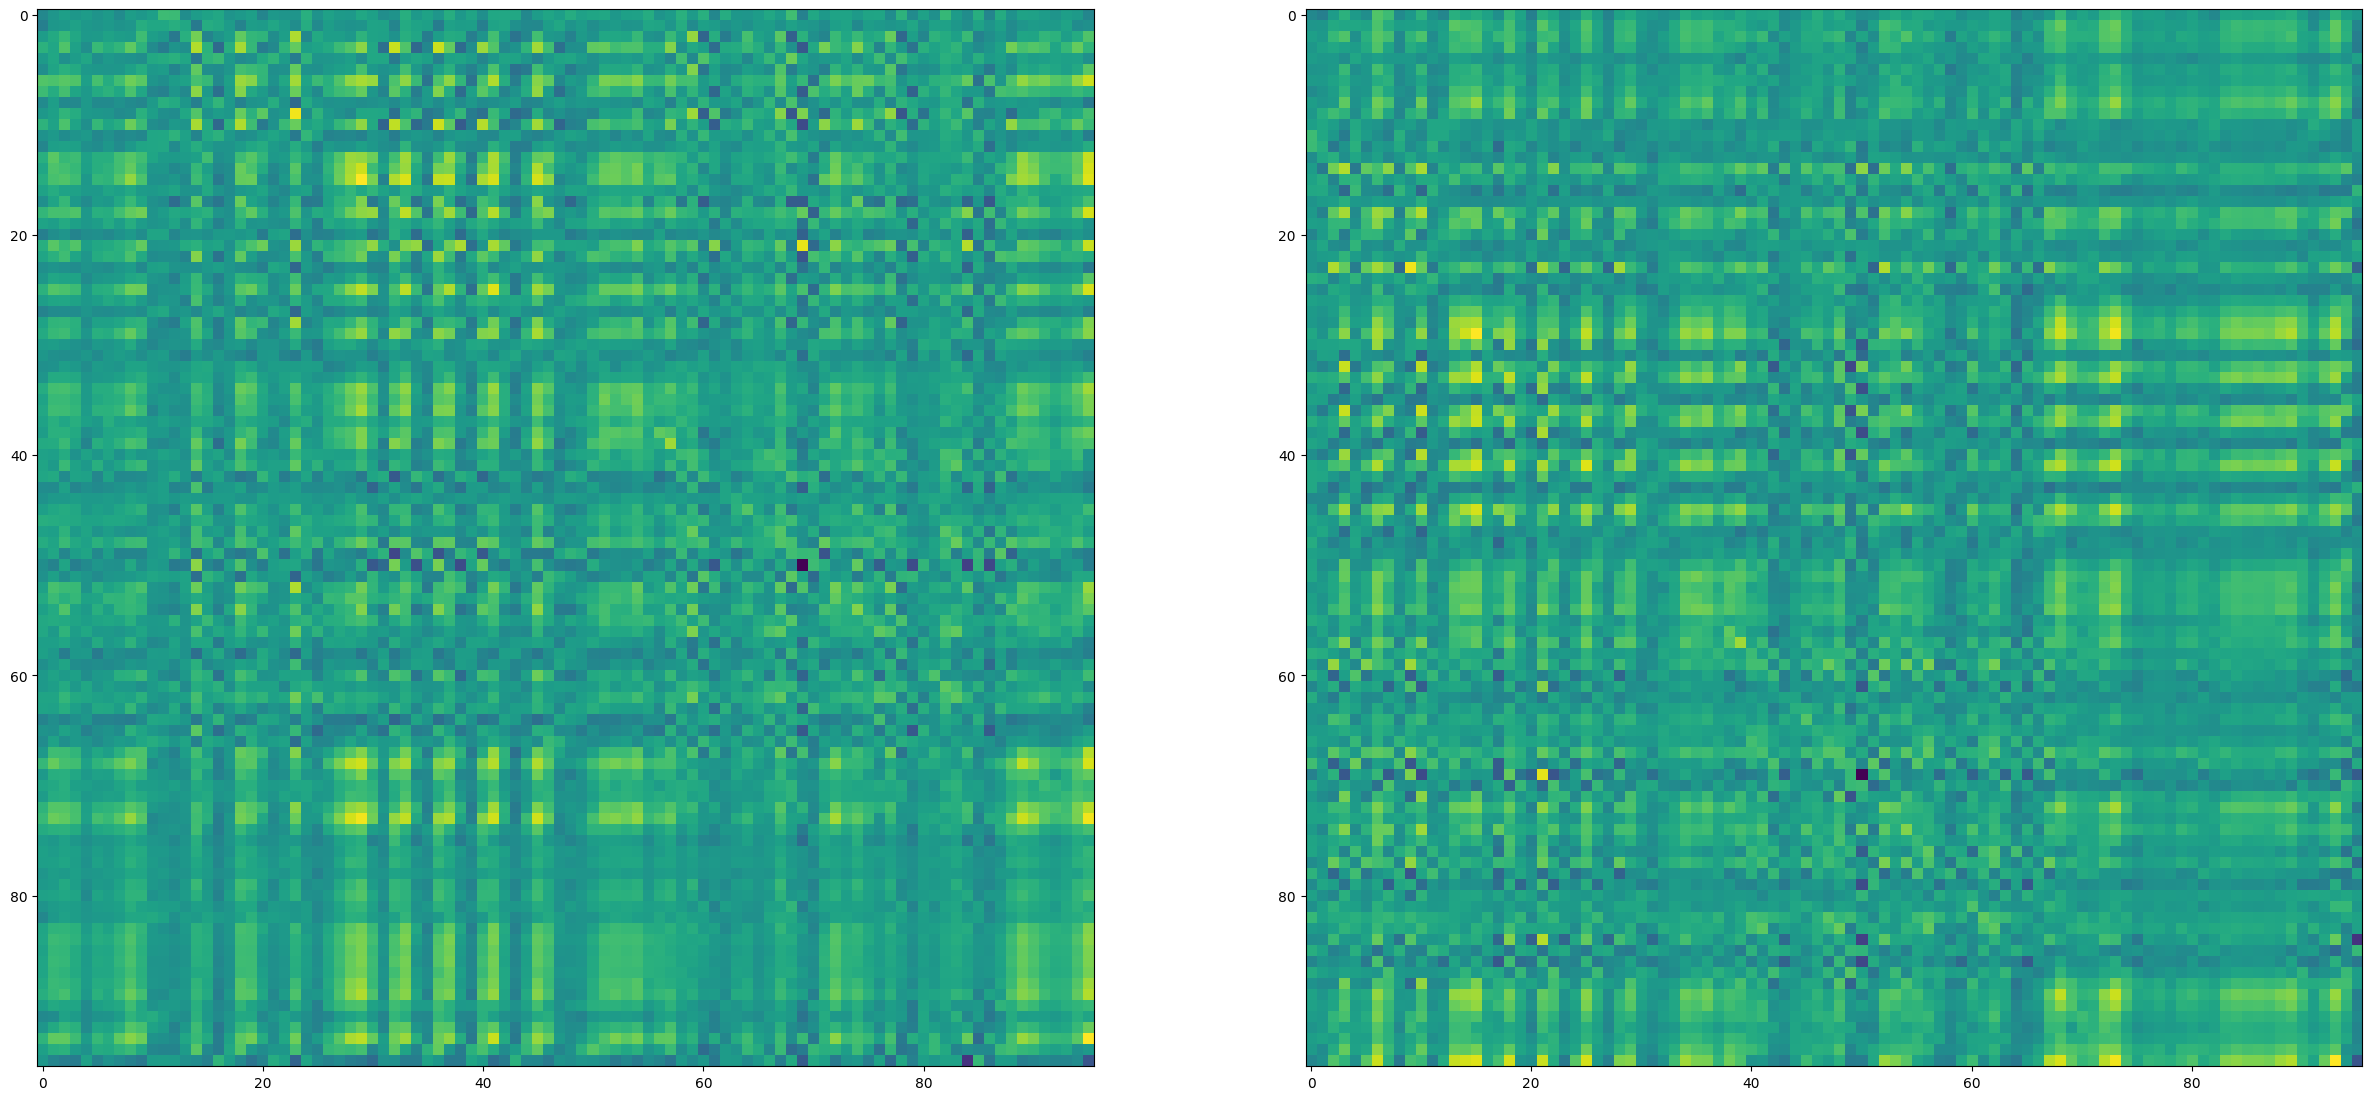

In [19]:
feat_left, feat_right, M_left_to_right, M_right_to_left = out
# feat, cost = out
# print(feat.shape)
# feat_left, feat_right = torch.chunk(feat, 2, dim=0)
# feat_left = feat_left.permute(0, 2, 1).reshape(1, -1, w_lr, w_lr)
# feat_right = feat_right.permute(0, 2, 1).reshape(1, -1, w_lr, w_lr)
# M_left_to_right, M_right_to_left = cost
# M_left_to_right = torch.softmax(M_left_to_right, dim=-1)
# M_right_to_left = torch.softmax(M_right_to_left, dim=-1)
print(M_left_to_right)
# M_left_to_right = M_left_to_right.clamp_(0)
# M_right_to_left = M_right_to_left.clamp_(0)
b,_,h,w = feat_left.shape
index = torch.arange(w).view(1, 1, 1, w).to(M_right_to_left.device).float()    # index: 1*1*1*w

disp1 = torch.sum(M_right_to_left * index, dim=-1).view(b, 1, h, w) # x axis of the corresponding point
# print(disp1)
disp2 = torch.sum(M_left_to_right * index, dim=-1).view(b, 1, h, w)
# print(out[2].shape)
feat_left = feat_left.squeeze(0)
feat_right = feat_right.squeeze(0)
M_left_to_right = M_left_to_right.squeeze(0)
M_right_to_left = M_right_to_left.squeeze(0)
disp1 = disp1.squeeze(0)
disp2 = disp2.squeeze(0)
gray_scale1 = torch.sum(M_left_to_right,0)
gray_scale1 = gray_scale1 / M_left_to_right.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale1 = gray_scale1.data.cpu().numpy()

gray_scale2 = torch.sum(M_right_to_left,0)
gray_scale2 = gray_scale2 / M_right_to_left.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale2 = gray_scale2.data.cpu().numpy()


fig = plt.figure(1, figsize=(30, 50))
plt.subplot(1,2,1)
img_plot = plt.imshow(gray_scale1)
fig2 = plt.figure(1, figsize=(30, 50))
plt.subplot(1,2,2)
img_plot2 = plt.imshow(gray_scale2)
# fig3 = plt.figure(1, figsize=(30, 50))
# plt.subplot(1,3,3)
# img_plot2 = plt.imshow(feat_right_pca)
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
# plt.savefig('vis/features_rightW&right.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
plt.savefig('vis/attention_map.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整

In [9]:
print(M_right_to_left)

tensor([[[ 0.0133,  0.0058,  0.0267,  ...,  0.0587,  0.0160,  0.0219],
         [ 0.0187,  0.0041,  0.0140,  ...,  0.0359,  0.0063,  0.0305],
         [ 0.0320,  0.0676,  0.0778,  ...,  0.0931,  0.0164,  0.0328],
         ...,
         [ 0.0372,  0.0327,  0.0394,  ...,  0.0611,  0.0402,  0.0454],
         [ 0.0299, -0.0106, -0.0027,  ...,  0.0122,  0.0295,  0.0316],
         [ 0.0486,  0.0440,  0.0657,  ...,  0.0645,  0.0266,  0.0554]],

        [[-0.0129,  0.0492,  0.0010,  ...,  0.0136, -0.0377,  0.0143],
         [ 0.0329,  0.0537,  0.0286,  ...,  0.0162, -0.0106,  0.0218],
         [ 0.0149,  0.0776,  0.0330,  ...,  0.0588,  0.0151,  0.0219],
         ...,
         [ 0.0265,  0.0431,  0.0253,  ...,  0.0269,  0.0157,  0.0275],
         [ 0.0179,  0.0419,  0.0176,  ...,  0.0139,  0.0114,  0.0203],
         [ 0.0355,  0.0709,  0.0128,  ...,  0.0295,  0.0092,  0.0167]],

        [[-0.0097,  0.0197, -0.0146,  ...,  0.0137, -0.0549, -0.0019],
         [ 0.0634,  0.0031,  0.0510,  ...,  0

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def gen_pos_shift(w, device):
    """
    Compute relative difference between each pixel location from left image to right image, to be used to calculate
    disparity

    :param w: image width
    :param device: torch device
    :return: relative pos shifts
    """
    pos_r = torch.linspace(0, w - 1, w)[None, None, None, :].to(device)  # 1 x 1 x 1 x W_right
    pos_l = torch.linspace(0, w - 1, w)[None, None, :, None].to(device)  # 1 x 1 x W_left x1
    pos = pos_r - pos_l
    pos[pos < 0] = 0
    return pos
        
def gen_raw_disp(attn_weight, pos_shift, occ_mask = None):
    # b, c, h, w = size
    # find high response area
    high_response = torch.argmax(attn_weight, dim=-1)  # NxHxW

    # build 3 px local window
    response_range = torch.stack([high_response - 1, high_response, high_response + 1], dim=-1)  # NxHxWx3

    # attention with re-weighting
    attn_weight_pad = F.pad(attn_weight, [1, 1], value=0.0)  # N x Hx W_left x (W_right+2)
    attn_weight_rw = torch.gather(attn_weight_pad, -1, response_range + 1)  # offset range by 1, N x H x W_left x 3

    # compute sum of attention
    norm = attn_weight_rw.sum(-1, keepdim=True)
    if occ_mask is None:
        norm[norm < 0.1] = 1.0
    else:
        norm[occ_mask, :] = 1.0  # set occluded region norm to be 1.0 to avoid division by 0

    # re-normalize to 1
    attn_weight_rw = attn_weight_rw / norm  # re-sum to 1
    pos_pad = F.pad(pos_shift, [1, 1]).expand_as(attn_weight_pad)
    pos_rw = torch.gather(pos_pad, -1, response_range + 1)

    # compute low res disparity
    disp_pred_low_res = (attn_weight_rw * pos_rw)  # NxHxW

    return disp_pred_low_res.sum(-1), norm



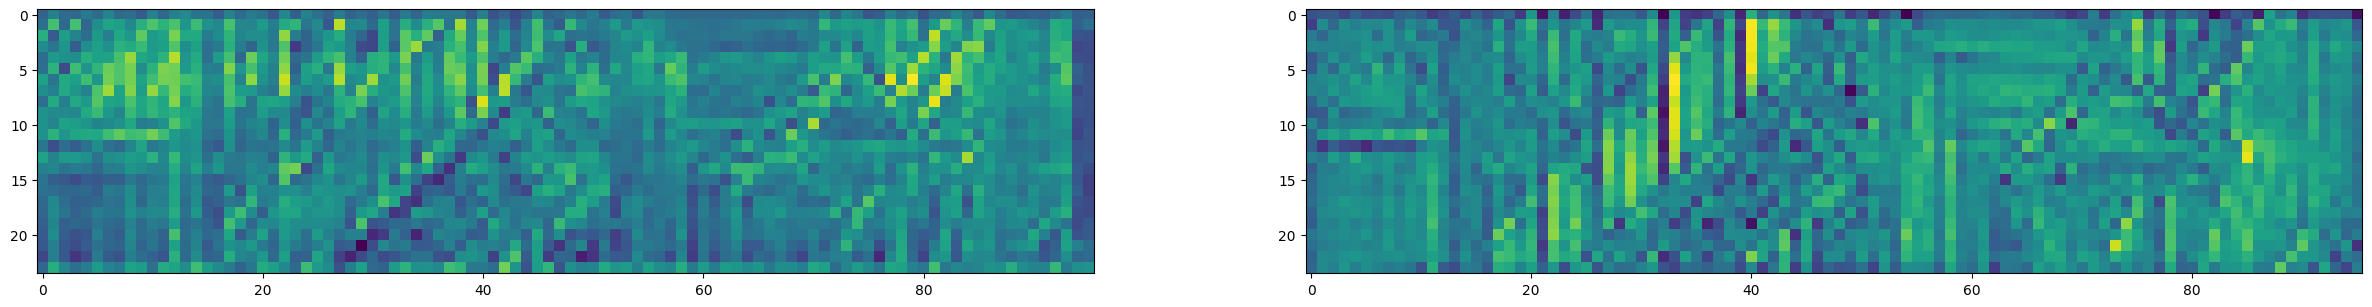

In [11]:
feat_leftW = torch.matmul(M_right_to_left, feat_right.permute(1,2,0)).permute(2,0,1)
feat_rightW = torch.matmul(M_left_to_right, feat_left.permute(1,2,0)).permute(2,0,1)

gray_scale = torch.sum(feat_rightW,0)
gray_scale = gray_scale / feat_left.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale = gray_scale.data.cpu().numpy()

gray_scale2 = torch.sum(feat_right,0)
gray_scale2 = gray_scale2 / feat_left.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale2 = gray_scale2.data.cpu().numpy()
gray_scale = gray_scale

fig = plt.figure(1, figsize=(30, 50))
plt.subplot(1,2,1)
img_plot = plt.imshow(gray_scale)
fig2 = plt.figure(1, figsize=(30, 50))
plt.subplot(1,2,2)
img_plot2 = plt.imshow(gray_scale2)
# fig3 = plt.figure(1, figsize=(30, 50))
# plt.subplot(1,3,3)
# img_plot2 = plt.imshow(feat_right_pca)
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
plt.savefig('vis/features_rightW&right.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整

In [12]:
# 计算heatmap
# heatmap = out.detach().cpu().numpy()
# heatmap = np.mean(heatmap, axis=0)
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
heatmap = torch.mean(feat_left, dim=0).detach().cpu().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
heatmap2 = torch.mean(feat_right, dim=0).detach().cpu().numpy()
heatmap2 = (heatmap2 - heatmap2.min()) / (heatmap2.max() - heatmap2.min())


# plt.matshow(heatmap)
# plt.show()
 
img = cv2.imread(img_path_L)  # 用cv2加载原始图像
img = img[x0: x0 + h_hr, y0: y0 + w_hr,:]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # 将热力图的大小调整为与原始图像相同
heatmap = np.uint8(255 * heatmap)  # 将热力图转换为RGB格式
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # 将热力图应用于原始图像
alpha = 0.
# 将两个图像进行叠加
blended_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0, dtype=cv2.CV_32F).astype(np.uint8)
# csuperimposed_img = heatmap + img  # 这里的0.4是热力图强度因子
cv2.imwrite('vis/heat_map_left.jpg', blended_img)  # 将图像保存到硬盘

img2 = cv2.imread(img_path_R)  # 用cv2加载原始图像
img2 = img2[x0: x0 + h_hr, y0: y0 + w_hr,:]
heatmap2 = cv2.resize(heatmap2, (img2.shape[1], img2.shape[0]))  # 将热力图的大小调整为与原始图像相同
heatmap2 = np.uint8(255 * heatmap2)  # 将热力图转换为RGB格式
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)  # 将热力图应用于原始图像
alpha = 0.
# 将两个图像进行叠加
blended_img2 = cv2.addWeighted(heatmap2, alpha, img2, 1 - alpha, 0, dtype=cv2.CV_32F).astype(np.uint8)
# csuperimposed_img = heatmap + img  # 这里的0.4是热力图强度因子
cv2.imwrite('vis/heat_map_right.jpg', blended_img2)  # 将图像保存到硬盘

True

In [12]:
print(M_left_to_right.shape)

torch.Size([24, 96, 96])


tensor([[[-255.8728, -134.5638,  -80.8045,  ..., -222.6583, -242.2238,
          -205.3608],
         [-199.8074, -124.2325,  -33.9048,  ...,  -88.0369, -105.2072,
           -64.6359],
         [-216.8033, -154.9798,  -17.9967,  ..., -123.5504,  -97.0762,
           -99.4628],
         ...,
         [-180.6015, -145.1712,  -46.8506,  ..., -108.8582,  -67.3673,
           -94.6861],
         [-105.0602,  -96.0067,   44.4506,  ...,  -79.6374,  -65.9535,
          -126.5271],
         [-322.3941, -259.8333,  -43.0193,  ..., -124.1586, -117.3606,
          -100.6854]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[[ 0.,  1.,  2.,  ..., 93., 94., 95.],
          [ 0.,  0.,  1.,  ..., 92., 93., 94.],
          [ 0.,  0.,  0.,  ..., 91., 92., 93.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  1.,  2.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]], device='cuda:0')
tensor([[[ 1.3403e+00, -6.9661e-01, -2.5518e-01,  ...,  0.000

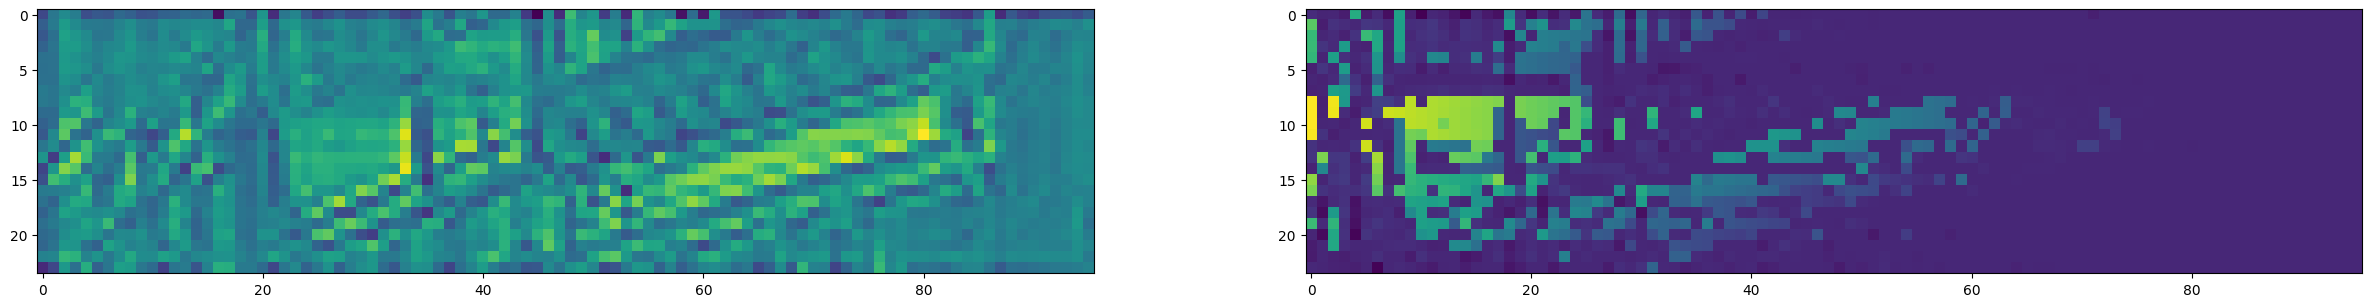

In [13]:
h,w,w = M_left_to_right.shape
index = torch.arange(w).view(1, 1, 1, w).to(M_right_to_left.device).float()    # index: 1*1*1*w
disp1 = torch.sum(M_right_to_left * index, dim=-1).view(1, h, w) # x axis of the corresponding point
#  disp2 = torch.sum(M_left_to_right * index, dim=-1).view(1, h, w)
print(disp1)
pos_shift = gen_pos_shift(96, 'cuda')
print(pos_shift)
disp2,norm = gen_raw_disp(M_left_to_right.unsqueeze(0), pos_shift)
disp2 = disp2
print(disp2)

# disp = disp.squeeze(0)
gray_scale = torch.sum(disp1,0)
gray_scale = gray_scale /disp1.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale = gray_scale.data.cpu().numpy()

gray_scale2 = torch.sum(disp2,0)
gray_scale2 = gray_scale2 /disp2.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale2 = gray_scale2.data.cpu().numpy()


fig = plt.figure(1, figsize=(30, 50))
plt.subplot(1,2,1)
img_plot = plt.imshow(gray_scale)
fig2 = plt.figure(1, figsize=(30, 50))
plt.subplot(1,2,2)
img_plot2 = plt.imshow(gray_scale2)
# fig3 = plt.figure(1, figsize=(30, 50))
# plt.subplot(1,3,3)
# img_plot2 = plt.imshow(feat_right_pca)
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
plt.savefig('vis/disp.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整
